# Load libraries and functions

In [2]:
setwd("~/work/ampra1")

In [3]:
library(knitr)
library(ggplot2)
library(mixtools)
library(dplyr)
library(janitor)
library(magrittr)
library(patchwork)
library(readxl)
library(reshape2)
library(MASS)

mixtools package, version 1.1.0, Released 2017-03-10
This package is based upon work supported by the National Science Foundation under Grant No. SES-0518772.


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select



In [4]:
source("R/meta_colors.R")

theme_clean <- function(base_size = 20, base_family = "") {
  theme_classic(
    base_size = base_size, base_family = base_family
  ) %+replace%
    theme(
      # axis.line = element_line(size = 0.5),
      axis.ticks = element_line(size = 0.25),
      strip.background = element_rect(size = 0),
      panel.background = element_rect(
        size = 0.5, color = "black"
      ),
      axis.line = element_blank()
    )
}


# Load data

In [5]:
d <- read_excel("data/postQC_all_samples.xlsx")
d <- d[1:51,]
d <- clean_names(d)
dim(d)
d[1:5,1:5]
print(sort(colnames(d)))

[1] 51 40

patient,disease,sex,age,tissue_type
301-0132,OA,M,64,arthro
301-0133,OA,F,67,arthro
301-0135,OA,F,66,arthro
301-0155,OA,F,72,arthro
301-0159,OA,F,81,arthro


 [1] "age"                                   
 [2] "anti_ccp"                              
 [3] "anti_ccp_pos"                          
 [4] "b_cells"                               
 [5] "bcells_ov_cd45pos"                     
 [6] "biopsy_site"                           
 [7] "cd34negcd90negfibroblast_ov_fibroblast"
 [8] "cd34negcd90posfibroblast_ov_fibroblast"
 [9] "cd34poscd90posfibroblast_ov_fibroblast"
[10] "cd3negcd14neg_ov_cd45pos"              
[11] "cd45neg_ov_live"                       
[12] "cd45pos_ov_live"                       
[13] "cd4_t_cells"                           
[14] "cd4tcells_ov_tcells"                   
[15] "cd8_t_cells"                           
[16] "cd8tcells_ov_tcells"                   
[17] "das28"                                 
[18] "data_access_group"                     
[19] "disease"                               
[20] "disease_duration"                      
[21] "disease_tissue"                        
[22] "endothelial_cells"          

In [6]:

d$type <- ifelse(startsWith(d$patient, "300"), "biopsy", "arthro")
# d$disease_assay <- d$disease_cohort
d$disease_assay <- paste(d$disease, d$tissue_type)

In [7]:
head(d)

patient,disease,sex,age,tissue_type,data_access_group,race,rf,rf_pos_neg,anti_ccp,⋯,b_cells,monocytes,cd4_t_cells,cd8_t_cells,memory_b_cells,endothelial_cells,lining_fibroblasts,sublining_fibroblasts,type,disease_assay
301-0132,OA,M,64,arthro,University of Rochester,White,n/a,n/a,n/a,⋯,0.01,0.25,0.02,0.01,0.16,0.02,0.78,0.10,arthro,OA arthro
301-0133,OA,F,67,arthro,University of Rochester,White,n/a,n/a,n/a,⋯,0.00,0.29,0.01,0.01,0.02,0.23,0.31,0.32,arthro,OA arthro
301-0135,OA,F,66,arthro,University of Rochester,White,n/a,n/a,n/a,⋯,0.00,0.09,0.07,0.03,0.05,0.47,0.05,0.39,arthro,OA arthro
301-0155,OA,F,72,arthro,Hospital for Special Surgeries,NR,n/a,n/a,n/a,⋯,0.00,0.14,0.01,0.00,0.05,0.12,0.42,0.30,arthro,OA arthro
301-0159,OA,F,81,arthro,Hospital for Special Surgeries,NR,n/a,n/a,n/a,⋯,0.00,0.27,0.02,0.01,0.06,0.06,0.54,0.27,arthro,OA arthro
301-0160,OA,F,69,arthro,Hospital for Special Surgeries,NR,n/a,n/a,n/a,⋯,0.00,0.08,0.04,0.01,0.09,0.30,0.04,0.52,arthro,OA arthro


# Mahalanobis distance

In [20]:
ix_oa <- d$disease == "OA"
x <- d[, c("t_cells", "b_cells", "monocytes")]
d$maha <- mahalanobis(x = x, center = colMeans(x[ix_oa,]), cov = cov(x[ix_oa,]))

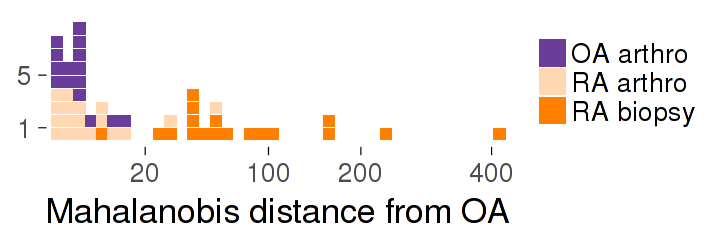

In [21]:
options(repr.plot.width = 6, repr.plot.height = 2)

ggplot(d, aes(x = maha, fill = disease_assay)) +
geom_histogram(bins = 40) +
geom_hline(yintercept = 0:8, color = "white", size = 0.2) +
scale_x_sqrt(breaks = c(20, 100, 200, 400), expand = c(0.01, 0)) +
scale_y_continuous(breaks = c(1, 5)) +
scale_fill_manual(name = NULL, values = meta_colors$disease_assay) +
theme_clean(base_size = 20) +
theme(panel.background = element_blank()) +
labs(y = NULL, x = "Mahalanobis distance from OA")

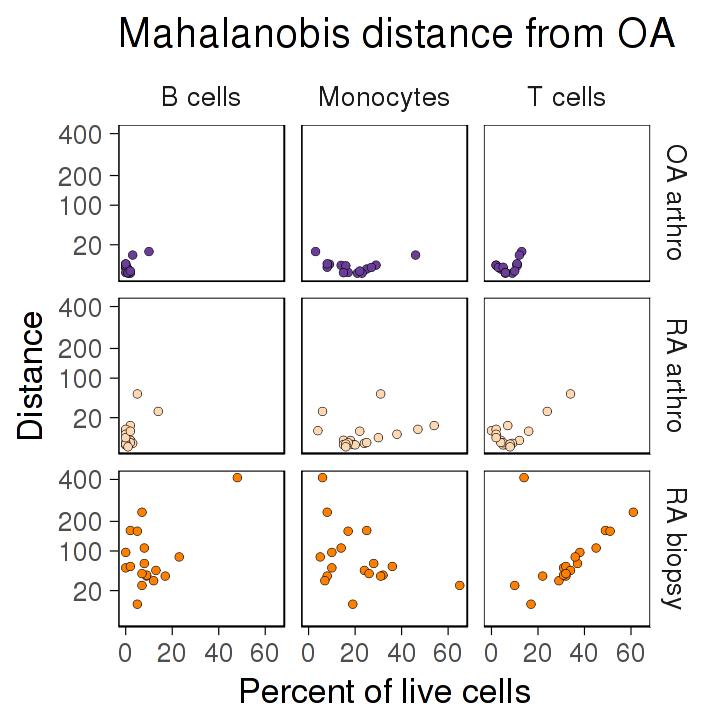

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6)

d_m <- melt(d[, c("disease_assay", "maha", "t_cells", "b_cells", "monocytes")], id.vars = c("disease_assay", "maha"))
d_m$variable <- as.character(d_m$variable)
d_m$variable[d_m$variable == "t_cells"] <- "T cells"
d_m$variable[d_m$variable == "b_cells"] <- "B cells"
d_m$variable[d_m$variable == "monocytes"] <- "Monocytes"

ggplot(d_m) +
geom_point(aes(y = maha, x = 100 * value, fill = disease_assay), shape = 21, size = 2, stroke = 0.2) +
facet_grid(disease_assay ~ variable) +
scale_y_sqrt(breaks = c(20, 100, 200, 400)) +
scale_fill_manual(values = meta_colors$disease_assay) +
theme_clean(base_size = 20) +
theme(legend.position = "none") +
labs(x = "Percent of live cells", y = "Distance", title = "Mahalanobis distance from OA")

In [11]:
d[which(d$disease_assay == "RA biopsy"),c("patient", "maha", "b_cells", "t_cells", "monocytes")]

patient,maha,b_cells,t_cells,monocytes
300-0121,6.611699,0.05,0.17,0.19
300-0528,26.924768,0.07,0.10,0.65
300-0122,410.052790,0.48,0.14,0.06
300-0153,42.284585,0.09,0.32,0.08
300-0211,96.157845,0.00,0.38,0.10
300-0213,34.208028,0.12,0.29,0.07
300-0451,58.433612,0.00,0.31,0.10
300-0481,165.459934,0.02,0.49,0.25
300-0482,68.132750,0.08,0.37,0.28
300-0483,61.491472,0.02,0.32,0.36


In [12]:
d[which(d$lymphocytes_live == 0.17),]

patient,disease,sex,age,tissue_type,data_access_group,race,rf,rf_pos_neg,anti_ccp,⋯,monocytes,cd4_t_cells,cd8_t_cells,memory_b_cells,endothelial_cells,lining_fibroblasts,sublining_fibroblasts,type,disease_assay,maha
300-0528,RA,F,38,biopsy,UK London,African American,169,Positive,2.2999999999999998,⋯,0.65,0.05,0.03,0.12,0.18,0.14,0.59,biopsy,RA biopsy,26.92477


In [13]:
d[d$patient == "300-0528", "maha"]

maha
26.92477


In [67]:
table(d$disease_assay, d$maha > 10)

           
            FALSE TRUE
  OA arthro    14    1
  RA arthro    15    3
  RA biopsy     1   17

# Fit two normal distributions

In [14]:
fit <- normalmixEM(x = d$lymphocytes_live)

sdnorm <- function(x, mean = 0, sd = 1, lambda = 1){
  lambda * dnorm(x, mean = mean, sd = sd)
}

dnorm2 <- function(fit) {
  return(function(x) {
    dnorm(x, mean = fit$mu[1], sd = fit$sigma[1]) * fit$lambda[1] -
      dnorm(x, mean = fit$mu[2], sd = fit$sigma[2]) * fit$lambda[2]
  })
}

root <- uniroot(dnorm2(fit), interval = c(0, 1))

d$Active <- d$lymphocytes_live > root$root
table(d$disease_assay, d$Active)

number of iterations= 47 


           
            FALSE TRUE
  OA arthro    14    1
  RA arthro    15    3
  RA biopsy     1   17

Warning message:
“Removed 3 rows containing missing values (geom_bar).”

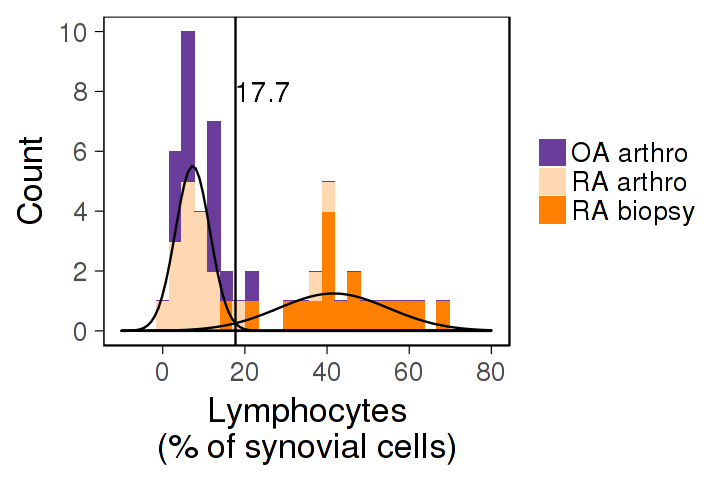

In [15]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(d) +
  geom_histogram(
    aes(x = lymphocytes_live, fill = disease_assay),
    bins = 30
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  stat_function(
    fun = sdnorm,
    args = list(
      mean = fit$mu[1],
      sd = fit$sigma[1],
      lambda = fit$lambda[1]
    ),
    color = "black", fill = NA, geom = "polygon"
  ) +
  stat_function(
    fun = sdnorm,
    args = list(
      mean = fit$mu[2],
      sd = fit$sigma[2],
      lambda = fit$lambda[2]
    ),
    color = "black", fill = NA, geom = "polygon"
  ) +
  geom_vline(xintercept = root$root) +
  annotate(
    geom = "text",
    x = root$root,
    y = 8,
    label = signif(100 * root$root, 3),
    hjust = 0, size = 6
  ) +
  scale_y_continuous(breaks = c(0, 2, 4, 6, 8, 10)) +
  scale_x_continuous(
    label = function(x) 100 * x,
    limits = c(-0.1, 0.8)
  ) +
  labs(x = "Lymphocytes\n(% of synovial cells)", y = "Count") +
  theme_clean(base_size = 20)

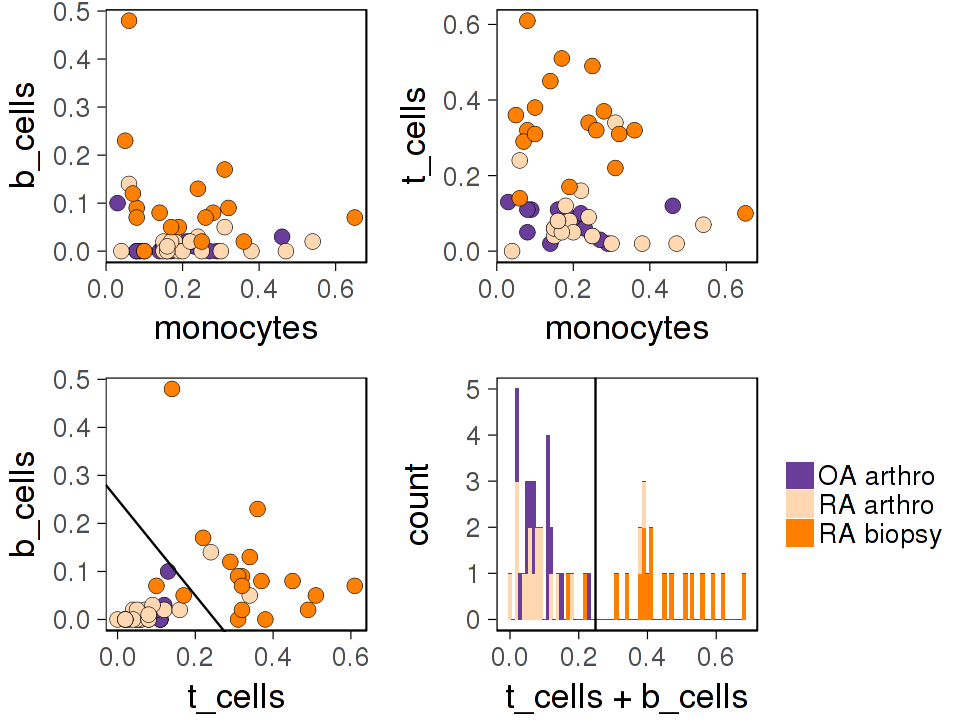

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)

p1 <- ggplot(d) +
  geom_point(
    aes(
      x = monocytes,
      y = b_cells,
      fill = disease_assay
    ),
    size = 4, shape = 21, stroke = 0.2
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  # scale_y_continuous(label = function(x) 100 * x) +
  theme_classic(base_size = 20) +
  theme_clean() + theme(legend.position = "none")

p2 <- ggplot(d) +
  geom_point(
    aes(
      x = monocytes,
      y = t_cells,
      fill = disease_assay
    ),
    size = 4, shape = 21, stroke = 0.2
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  # scale_y_continuous(label = function(x) 100 * x) +
  theme_classic(base_size = 20) +
  theme_clean() + theme(legend.position = "none")

p3 <- ggplot(d) +
  geom_point(
    aes(
      x = t_cells,
      y = b_cells,
      fill = disease_assay
    ),
    size = 4, shape = 21, stroke = 0.2
  ) +
  geom_abline(slope = -1, intercept = 0.25) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  # scale_y_continuous(label = function(x) 100 * x) +
  theme_classic(base_size = 20) +
  theme_clean() + theme(legend.position = "none")

p4 <- ggplot(d) +
  geom_histogram(
    aes(
      x = t_cells + b_cells,
      fill = disease_assay
    ),
    binwidth = 0.01
  ) +
  geom_vline(xintercept = 0.25) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  # scale_y_continuous(label = function(x) 100 * x) +
  theme_classic(base_size = 20) +
  theme_clean()

p1 + p2 + p3 + p4 + plot_layout(ncol = 2)


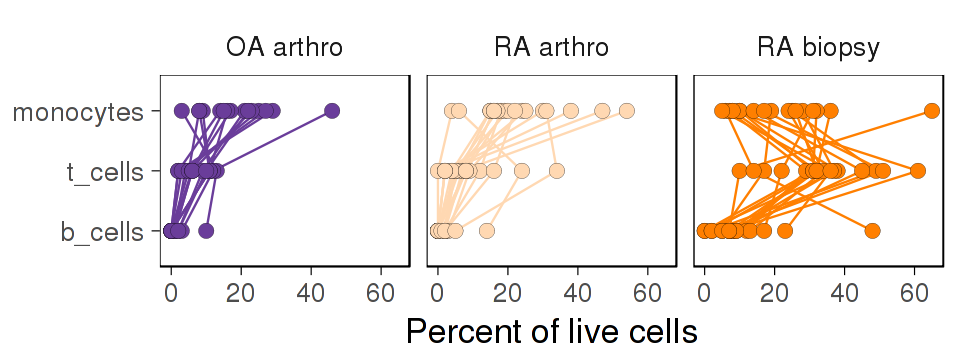

In [17]:
d$inflamed <- "OA"
ix <- d$disease == "RA" & d$lymphocytes_live > 0.25
d$inflamed[ix] <- "Inflamed RA"
ix <- d$disease == "RA" & d$lymphocytes_live <= 0.25
d$inflamed[ix] <- "Non-inflamed RA"
d$inflamed <- factor(d$inflamed, c("OA", "Non-inflamed RA", "Inflamed RA"))

dd <- melt(
  data = d,
  id.vars = c("patient", "disease_assay", "inflamed"),
  measure.vars = c(
    "b_cells", "t_cells", "monocytes"
    #, "endothelial_cells", "sublining_fibroblasts"
  )
)

options(repr.plot.width = 8, repr.plot.height = 3)
ggplot(dd) +
  geom_path(
    aes(
      x = variable, y = value * 100, group = patient,
      color = disease_assay
    )
  ) +
  geom_point(
    aes(
      x = variable, y = value * 100, group = disease_assay,
      fill = disease_assay
    ),
    # position = position_dodge(width = 0.5),
    size = 4, shape = 21, stroke = 0.1
  ) +
  scale_color_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  theme_clean(base_size = 20) +
  labs(x = NULL, y = "Percent of live cells") +
  facet_wrap(~ disease_assay) +
  coord_flip() +
  theme(legend.position = "none")


# Linear Discriminant Analysis

Discard the `RA arthro` samples and train an LDA model to discriminate between `OA arthro` and `RA biopsy`.

Then classify all the samples with the trained model.

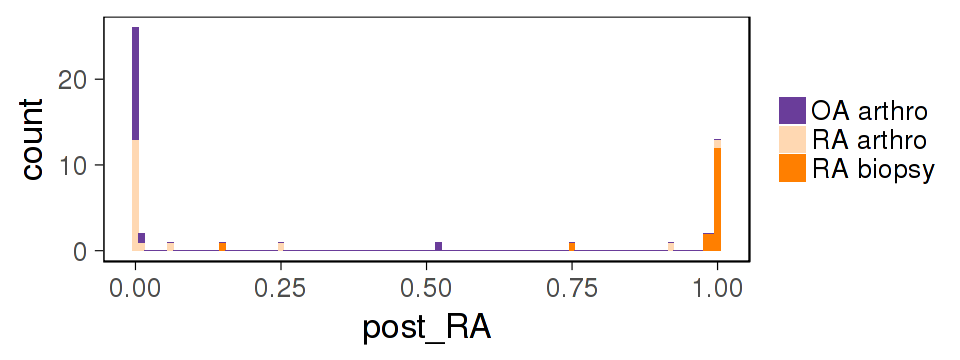

In [18]:
d_lda <- d[,c("disease_assay", "b_cells", "t_cells", "monocytes")]
d_lda <- subset(d_lda, disease_assay != "RA arthro")
mod <- lda(formula = disease_assay ~ ., data = d_lda)

post <- predict(
  mod, d[,c("disease_assay", "b_cells", "t_cells", "monocytes")]
)$posterior
colnames(post) <- c("post_OA", "post_RA")
post <- cbind(d, post)

# post_m <- melt(data = post, id.vars = c(""))

options(repr.plot.width = 8, repr.plot.height = 3)

ggplot(post) +
  geom_histogram(
    aes(x = post_RA, fill = disease_assay),
    binwidth = 0.01
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  theme_clean(base_size = 20)


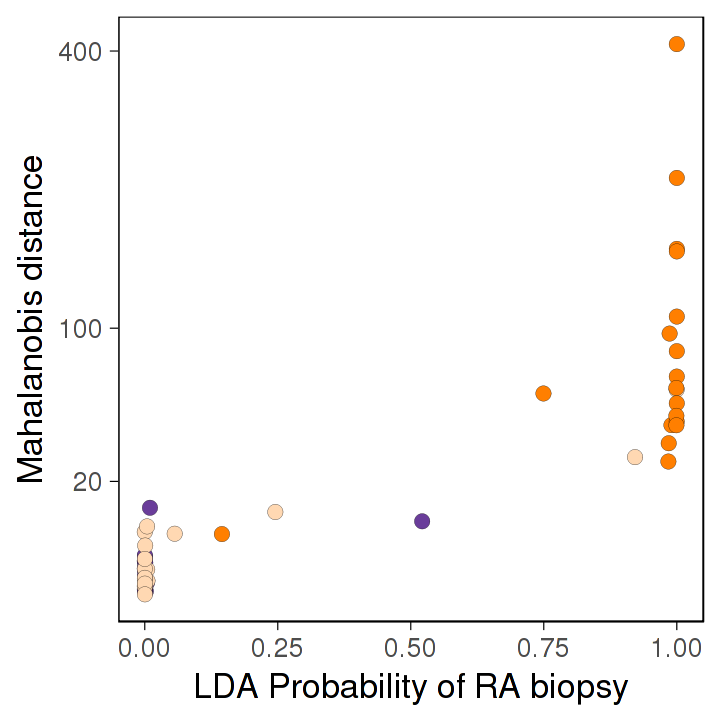

In [31]:
options(repr.plot.width = 6, repr.plot.height = 6)

ggplot(post) +
  geom_point(
    aes(
      x = post_RA, y = maha, fill = disease_assay
    ),
    shape = 21, size = 4, stroke = 0.1
  ) +
scale_y_sqrt(breaks = c(20, 100, 400)) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  theme_clean(base_size = 20) +
  labs(x = "LDA Probability of RA biopsy", y = "Mahalanobis distance") +
  theme(legend.position = "none")


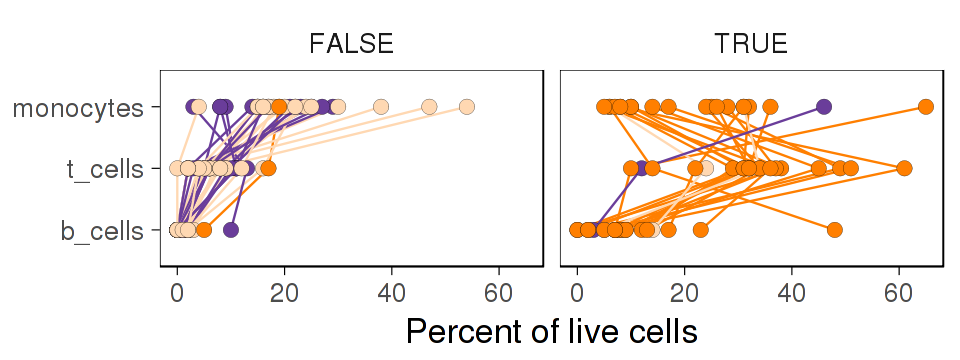

In [19]:
d$lda_inflamed <- post$post_RA > 0.5

dd <- melt(
  data = d,
  id.vars = c("patient", "disease_assay", "lda_inflamed", "inflamed"),
  measure.vars = c(
    "b_cells", "t_cells", "monocytes"
    #, "endothelial_cells", "sublining_fibroblasts"
  )
)

ggplot(dd) +
  geom_path(
    aes(
      x = variable, y = value * 100, group = patient,
      color = disease_assay
    )
  ) +
  geom_point(
    aes(
      x = variable, y = value * 100, group = disease_assay,
      fill = disease_assay
    ),
    # position = position_dodge(width = 0.5),
    size = 4, shape = 21, stroke = 0.1
  ) +
  scale_color_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  scale_fill_manual(
    values = meta_colors$disease_assay,
    name = NULL
  ) +
  theme_clean(base_size = 20) +
  labs(x = NULL, y = "Percent of live cells") +
#   facet_wrap(~ disease_assay) +
  facet_wrap(~ lda_inflamed) +
  coord_flip() +
  theme(legend.position = "none")


# Logistic regression

In [ ]:
# mod0 <- glm(
#   formula = disease_assay == "RA biopsy" ~ 1 + t_cells + b_cells,
#   data = d_lda,
#   family = binomial()
# )
# mod1 <- glm(
#   formula = disease_assay == "RA biopsy" ~ 1 + t_cells + b_cells + monocytes,
#   data = d_lda,
#   family = binomial()
# )
# mod2 <- glm(
#   formula = disease_assay == "RA biopsy" ~ 1 + monocytes + t_cells,
#   data = d_lda,
#   family = binomial()
# )